In [27]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [34]:
# Config
img_size = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = len(os.listdir("cleaned_data/train"))

# ===============================
# 1. Data Augmentation & Loading
# ===============================
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_validation = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = datagen_train.flow_from_directory(
    "cleaned_data/train/",
    target_size=img_size,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

validation_generator = datagen_validation.flow_from_directory(
    "cleaned_data/test/",
    target_size=img_size,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 400 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [35]:
# Load ResNet50 (similar to VGGFace 'resnet50') pretrained on ImageNet
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

# Unfreeze top ResNet layers
for layer in base_model.layers[-40:]:  # unfreeze last 40 layers
    layer.trainable = True

In [36]:
# Add custom classification layers
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.25)(x)


output = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

In [37]:
model.compile(
    optimizer=Adam(1e-5),
    loss=[ 'categorical_crossentropy'],
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,247,944 (92.50 MB)

 Trainable params: 24,194,824 (92.30 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("face_model.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reducing_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
callbacks = [checkpoint,reducing_lr]

In [39]:

history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1191 - loss: 5.5377
Epoch 1: saving model to model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 275s 8s/step - accuracy: 0.1209 - loss: 5.5363 - val_accuracy: 0.1625 - val_loss: 5.4460 - learning_rate: 1.0000e-05
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2687 - loss: 5.3196
Epoch 2: saving model to model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 0.2692 - loss: 5.3185 - val_accuracy: 0.3187 - val_loss: 5.3074 - learning_rate: 1.0000e-05
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3897 - loss: 5.1687
Epoch 3: saving model to model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 181s 7s/step - accuracy: 0.3906 - loss: 5.1683 - val_accuracy: 0.4875 - val_loss: 5.1401 - learning_rate: 1.0000e-05
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5075 - loss: 5.0400
Epoch 4: saving model to model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.5082 - loss: 5

In [40]:
model.evaluate(validation_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 772ms/step - accuracy: 0.9207 - loss: 3.5992


[3.5464961528778076, 0.9375]

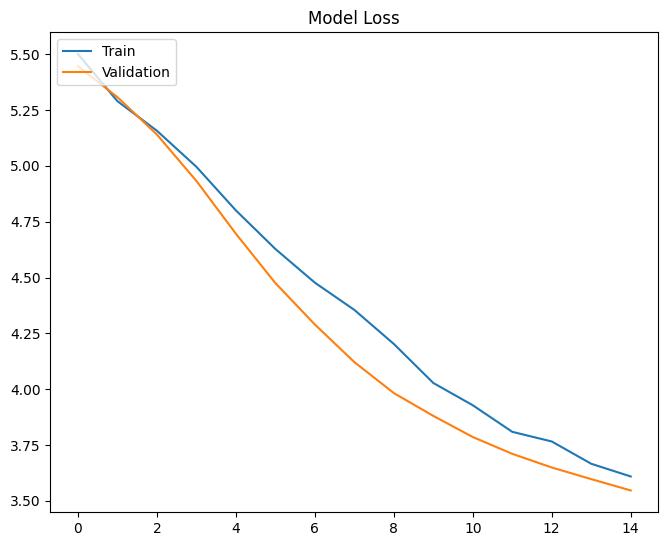

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

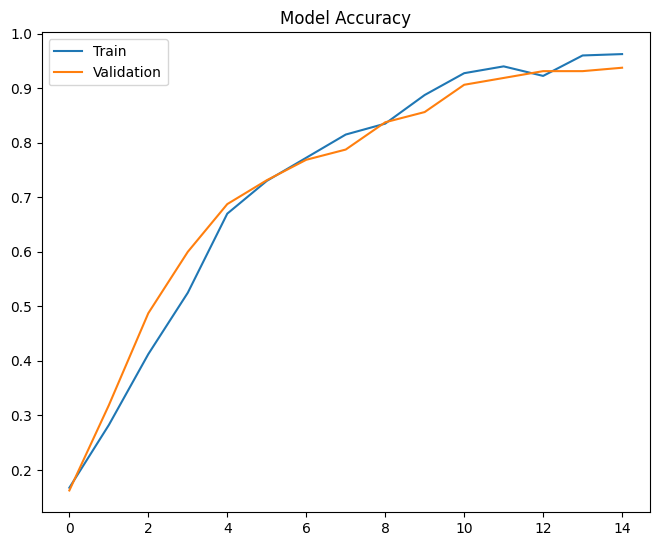

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on validation set
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 729ms/step
Confusion Matrix:
 [[19  1  0  0  0  0  0  0]
 [ 0 19  1  0  0  0  0  0]
 [ 2  1 14  0  2  0  0  1]
 [ 0  0  1 18  0  0  1  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0 20]]
                  precision    recall  f1-score   support

   001_Amir_khan       0.90      0.95      0.93        20
  002_Tony_Stark       0.90      0.95      0.93        20
003_Steve_Rogers       0.88      0.70      0.78        20
     004_Natasha       1.00      0.90      0.95        20
        005_Thor       0.91      1.00      0.95        20
        006_Loki       1.00      1.00      1.00        20
       007_Wanda       0.95      1.00      0.98        20
       008_Peter       0.95      1.00      0.98        20

        accuracy                           0.94       160
       macro avg       0.94      0.94      0.94       160
    weighted avg       0.94      0.94      0.94       160



In [44]:
model.save("face_model.h5")
